In [2]:
import os

from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType

import requests
from io import BytesIO
from zipfile import ZipFile
from neo4j_parallel_spark_loader.predefined_components import group_and_batch_spark_dataframe
from neo4j_parallel_spark_loader import ingest_spark_dataframe
from neo4j_parallel_spark_loader.visualize import create_ingest_heatmap
import json

load_dotenv()

True

## Create spark session
Update the values below for your environment

In [2]:
spark_executor_count=5

spark = (
    SparkSession.builder
    .appName("ReditThreads")
    .config("neo4j.url", os.environ.get("NEO4J_URI"))
    .config("url", os.environ.get("NEO4J_URI"))
    .config("neo4j.authentication.basic.username", os.environ.get("USERNAME"))
    .config("neo4j.authentication.basic.password", os.environ.get("NEO4J_PASSWORD"))
    .config("neo4j.database", os.environ.get("NEO4J_DATABASE"))
    .getOrCreate()
)

25/01/12 16:04:43 WARN Utils: Your hostname, Nathans-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.86.181 instead (on interface en0)
25/01/12 16:04:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/12 16:04:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Download data

In [3]:
schema = StructType([
    StructField("graph_id", IntegerType(), True),
    StructField("source_id", IntegerType(), True),
    StructField("target_id", IntegerType(), True)
])

# Download and read the zip file content
response = requests.get("https://snap.stanford.edu/data/reddit_threads.zip")
zip_file = ZipFile(BytesIO(response.content))

# Read the JSON file content from the zip
with zip_file.open("reddit_threads/reddit_edges.json") as file:
    # Parse JSON content
    data = json.loads(file.read().decode('utf-8'))
    flattened = [[int(t[0]), int(sublist[0]), int(sublist[1])] for t in data.items() for sublist in t[1]]
    
    # Create DataFrame from parsed JSON
    reddit_df = spark.createDataFrame(flattened, schema=schema)

# Show the result
reddit_df.show()

25/01/12 16:05:54 WARN TaskSetManager: Stage 0 contains a task of very large size (5590 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 16:06:00 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+--------+---------+---------+
|graph_id|source_id|target_id|
+--------+---------+---------+
|       0|        0|        2|
|       0|        1|        5|
|       0|        2|        4|
|       0|        2|        5|
|       0|        2|        6|
|       0|        2|        7|
|       0|        2|        8|
|       0|        2|        9|
|       0|        2|       10|
|       0|        3|        8|
|       1|        0|        3|
|       1|        0|        6|
|       1|        1|        8|
|       1|        2|        8|
|       1|        4|        8|
|       1|        5|        8|
|       1|        6|        8|
|       1|        7|        8|
|       1|        8|        9|
|       1|        8|       10|
+--------+---------+---------+
only showing top 20 rows



In [4]:
reddit_df.count()

25/01/12 16:06:02 WARN TaskSetManager: Stage 1 contains a task of very large size (5590 KiB). The maximum recommended task size is 1000 KiB.


5074915

## Load nodes

In [65]:
node_df = (reddit_df
            .select('graph_id', 'source_id')
            .withColumnRenamed('source_id', 'nodeId')
            .union(
                reddit_df
                .select('graph_id', 'target_id')
                .withColumnRenamed('target_id', 'nodeId'))
                .dropDuplicates())
node_df.count()

StatementMeta(medium, 26, 64, Finished, Available, Finished)

4859280

In [66]:
(
    node_df.write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("labels", ":Node")
    .option("node.keys", "graph_id:graphId,nodeId:nodeId")
    .option("schema.optimization.node.keys", "KEY")
    .save()
)

StatementMeta(medium, 26, 65, Finished, Available, Finished)

## Load rels

In [5]:
rel_batch_df = group_and_batch_spark_dataframe(spark_dataframe=reddit_df, 
                                               partition_col='graph_id', 
                                               num_groups=spark_executor_count)

25/01/12 16:06:08 WARN TaskSetManager: Stage 4 contains a task of very large size (5590 KiB). The maximum recommended task size is 1000 KiB.


In [6]:
rel_batch_df.show()

25/01/12 16:06:28 WARN TaskSetManager: Stage 12 contains a task of very large size (5590 KiB). The maximum recommended task size is 1000 KiB.
25/01/12 16:06:32 WARN PythonRunner: Detected deadlock while completing task 2.0 in stage 12 (TID 25): Attempting to kill Python Worker
25/01/12 16:06:32 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 12 (TID 23): Attempting to kill Python Worker
25/01/12 16:06:32 WARN PythonRunner: Detected deadlock while completing task 1.0 in stage 12 (TID 24): Attempting to kill Python Worker
25/01/12 16:06:32 WARN PythonRunner: Detected deadlock while completing task 4.0 in stage 12 (TID 27): Attempting to kill Python Worker
25/01/12 16:06:32 WARN PythonRunner: Detected deadlock while completing task 3.0 in stage 12 (TID 26): Attempting to kill Python Worker
25/01/12 16:06:32 WARN PythonRunner: Detected deadlock while completing task 7.0 in stage 12 (TID 30): Attempting to kill Python Worker
25/01/12 16:06:32 WARN PythonRunner: Detec

+--------+---------+---------+-----+-----+
|graph_id|source_id|target_id|group|batch|
+--------+---------+---------+-----+-----+
|       0|        0|        2|    0|    0|
|       0|        1|        5|    0|    0|
|       0|        2|        4|    0|    0|
|       0|        2|        5|    0|    0|
|       0|        2|        6|    0|    0|
|       0|        2|        7|    0|    0|
|       0|        2|        8|    0|    0|
|       0|        2|        9|    0|    0|
|       0|        2|       10|    0|    0|
|       0|        3|        8|    0|    0|
|       1|        0|        3|    3|    0|
|       1|        0|        6|    3|    0|
|       1|        1|        8|    3|    0|
|       1|        2|        8|    3|    0|
|       1|        4|        8|    3|    0|
|       1|        5|        8|    3|    0|
|       1|        6|        8|    3|    0|
|       1|        7|        8|    3|    0|
|       1|        8|        9|    3|    0|
|       1|        8|       10|    3|    0|
+--------+-

25/01/12 16:07:41 WARN TaskSetManager: Stage 35 contains a task of very large size (5590 KiB). The maximum recommended task size is 1000 KiB.


<Axes: title={'center': 'Parallel Ingest Heat Map'}, xlabel='Group Number', ylabel='Batch'>

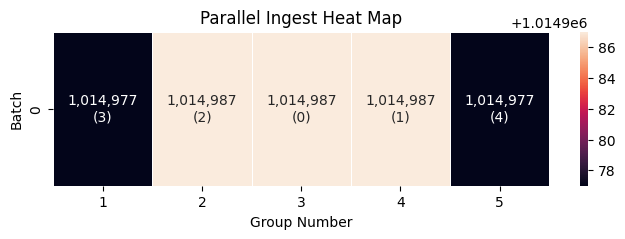

In [9]:
create_ingest_heatmap(rel_batch_df, figsize=(8, 2))

In [71]:
query = """
    MATCH(source:Node {graphId: event.graph_id, nodeId: event.source_id})
    MATCH(target:Node {graphId: event.graph_id, nodeId: event.target_id})
    MERGE(source)-[r:RELATES_TO]->(target)
    """

ingest_spark_dataframe(
    spark_dataframe=rel_batch_df,
    save_mode= "Overwrite",
    options={"query":query}
)

StatementMeta(medium, 26, 70, Finished, Available, Finished)

## Delete rels

In [72]:
rel_count = reddit_df.count()
batch_count = rel_count // 10000 + 1
print(rel_count, batch_count)

StatementMeta(medium, 26, 71, Finished, Available, Finished)

5074915 508


In [73]:
from pyspark.sql.functions import lit
del_df = (spark.range(batch_count)
    .select(lit(1).alias("id")))
print(del_df.count())

StatementMeta(medium, 26, 72, Finished, Available, Finished)

508


In [74]:
del_query = """
    MATCH ()-[r:RELATES_TO]->()
    WITH r LIMIT 10000
    DELETE r"""

(
    del_df.coalesce(1).write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("query", del_query)
    .option("batch.size", 1)
    .save()
)

StatementMeta(medium, 26, 73, Finished, Available, Finished)

## Load rels serially

In [75]:
(
    reddit_df.coalesce(1).write
    .format("org.neo4j.spark.DataSource")
    .mode("Overwrite")
    .option("query", query)
    .save()
)

StatementMeta(medium, 26, 74, Finished, Available, Finished)